In [2]:
! pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.5 MB/s eta 0:00:00


In [3]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import learning_curve
from sklearn.calibration import CalibrationDisplay

In [5]:
# Cargar los datos
df = pd.read_csv('healthcare_dataset_limpio.csv')
print("Dimensiones del dataset:", df.shape)
print("\nPrimeras filas del dataset:")
df.head()


Dimensiones del dataset: (54966, 17)

Primeras filas del dataset:


,Blood Type,Medical Condition,Insurance Provider,Billing Amount,Room Number,Admission Type,Medication,Test Results,Stay Duration,Categoria Edad,Discriminated,Doctor Code,Hospital Code,test_norm,med_norm,score_Triage,Triage
0,5,2,1,18856.281306,328,2,3,2,2,0,1,26320,29933,1.0,0.75,0.9,0
1,0,5,3,33643.327287,265,1,1,1,6,1,0,33355,16012,0.5,0.25,0.4,2
2,1,5,0,27955.096079,205,1,0,2,15,1,0,37534,5473,1.0,0.00,0.6,2
3,6,3,3,37909.782410,450,0,1,0,30,0,0,22226,12317,0.0,0.25,0.1,1
4,2,2,0,14238.317814,458,2,4,0,20,0,1,20973,33598,0.0,1.00,0.4,2


In [6]:
# Separar características (X) y variable objetivo (y)
X = df.drop(columns=['Discriminated','Doctor Code','Blood Type'])
y = df['Discriminated']
y = y.astype('int')

In [7]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [8]:
# Definir función objetivo para Optuna
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None])
    }

    model = RandomForestClassifier(**param, random_state=42)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='f1_weighted')

    return scores.mean()

In [9]:
# Optimización de hiperparámetros
print("\nOptimizando hiperparámetros con Optuna...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("\nMejores hiperparámetros encontrados:")
print(study.best_params)

[I 2024-12-20 18:08:37,546] A new study created in memory with name: no-name-b544674b-a7ce-45e2-88e9-382a724a8454



Optimizando hiperparámetros con Optuna...


[I 2024-12-20 18:09:02,937] Trial 0 finished with value: 0.9987491986966 and parameters: {'n_estimators': 143, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'log2', 'class_weight': None}. Best is trial 0 with value: 0.9987491986966.
[I 2024-12-20 18:09:32,477] Trial 1 finished with value: 0.9988174219196786 and parameters: {'n_estimators': 193, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.9988174219196786.
[I 2024-12-20 18:09:54,674] Trial 2 finished with value: 0.9987264585385862 and parameters: {'n_estimators': 146, 'max_depth': 8, 'min_samples_split': 17, 'min_samples_leaf': 10, 'max_features': 'log2', 'class_weight': None}. Best is trial 1 with value: 0.9988174219196786.
[I 2024-12-20 18:09:59,938] Trial 3 finished with value: 0.9987491987612778 and parameters: {'n_estimators': 54, 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 8, 'm


Mejores hiperparámetros encontrados:
{'n_estimators': 118, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'class_weight': None}


In [10]:
# Entrenar Random Forest con parámetros optimizados
print("\nEntrenando modelo Random Forest optimizado...")
rf_model = RandomForestClassifier(**study.best_params, random_state=42)
rf_model.fit(X_train, y_train)


Entrenando modelo Random Forest optimizado...


RandomForestClassifier(max_depth=28, min_samples_leaf=2, min_samples_split=3,
                       n_estimators=118, random_state=42)

In [11]:
# Realizar predicciones
rf_predictions = rf_model.predict(X_test)
print("\nRandom Forest Accuracy:", accuracy_score(y_test, rf_predictions))
print("\nReporte de clasificación (Random Forest):\n", classification_report(y_test, rf_predictions))



Random Forest Accuracy: 0.9996361651810078

Reporte de clasificación (Random Forest):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5497
           1       1.00      1.00      1.00      5497

    accuracy                           1.00     10994
   macro avg       1.00      1.00      1.00     10994
weighted avg       1.00      1.00      1.00     10994



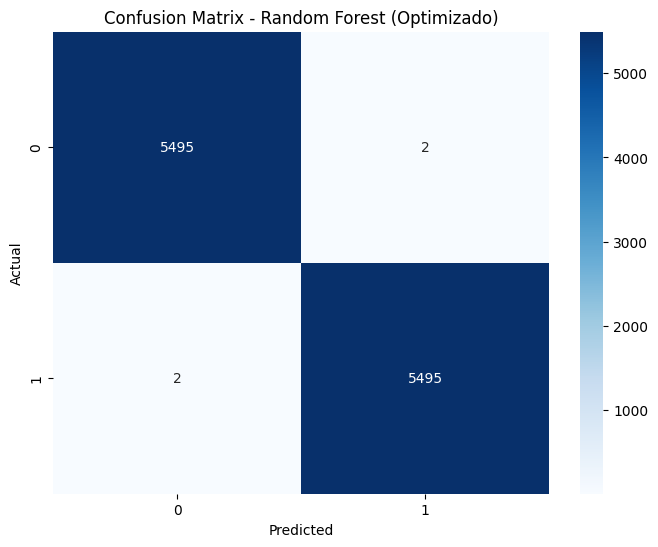

In [12]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_test, rf_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest (Optimizado)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [13]:
# Evaluar el desempeño en entrenamiento y prueba
rf_train_predictions = rf_model.predict(X_train)
train_accuracy = accuracy_score(y_train, rf_train_predictions)
test_accuracy = accuracy_score(y_test, rf_predictions)

print("\nEvaluación del modelo:")
print(f"Random Forest Accuracy (Train): {train_accuracy:.4f}")
print(f"Random Forest Accuracy (Test): {test_accuracy:.4f}")
print(f"Diferencia (Train - Test): {train_accuracy - test_accuracy:.4f}")


Evaluación del modelo:
Random Forest Accuracy (Train): 0.9999
Random Forest Accuracy (Test): 0.9996
Diferencia (Train - Test): 0.0003


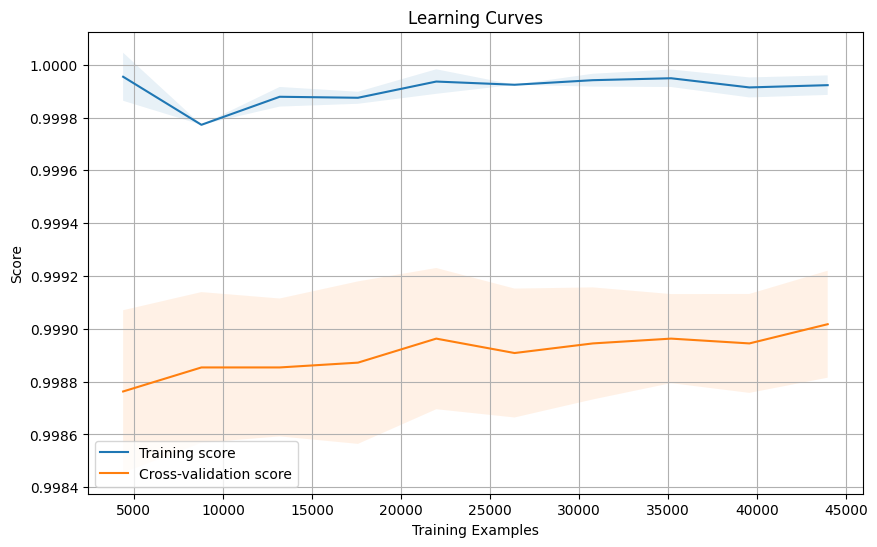

In [14]:
# Curvas de aprendizaje
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes, train_scores, val_scores = learning_curve(
    rf_model, X, y, cv=5, n_jobs=-1,
    train_sizes=train_sizes,
    scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score')
plt.plot(train_sizes, val_mean, label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.title('Learning Curves')
plt.legend(loc='best')
plt.grid(True)
plt.show()

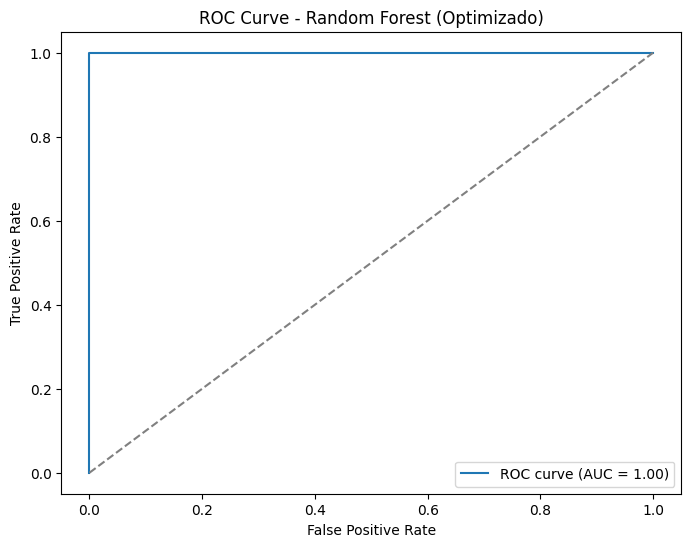

In [15]:
# Curva ROC
model_probabilities = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, model_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("ROC Curve - Random Forest (Optimizado)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

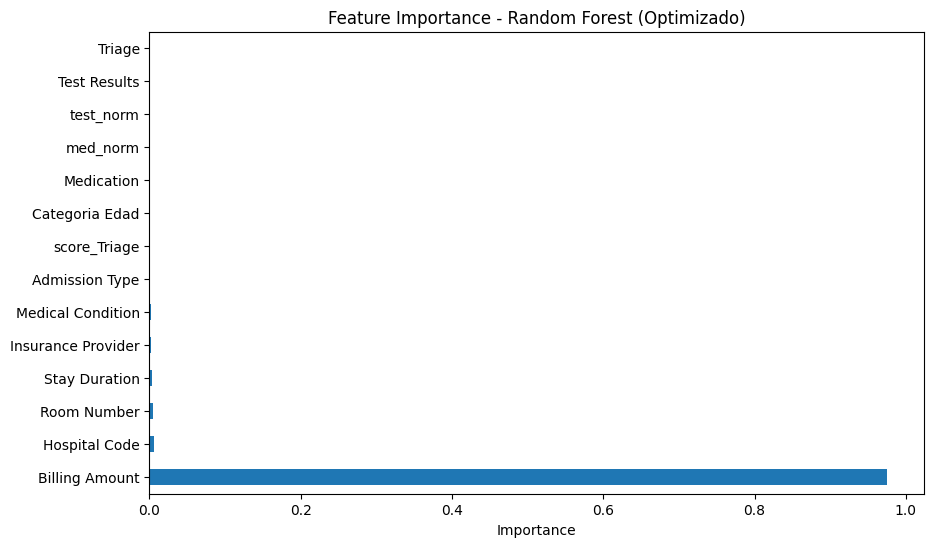

In [16]:
# Importancia de características
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
feature_importances.nlargest(15).plot(kind='barh')
plt.title("Feature Importance - Random Forest (Optimizado)")
plt.xlabel("Importance")
plt.show()

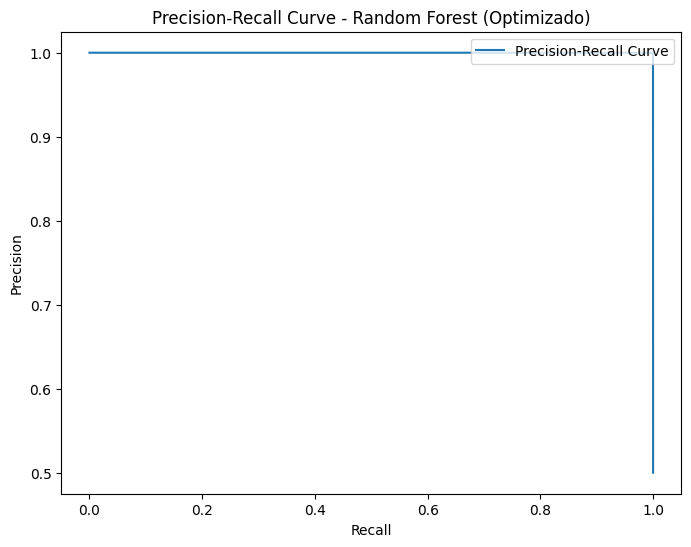

In [17]:
# Curva Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_test, model_probabilities)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.title("Precision-Recall Curve - Random Forest (Optimizado)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="upper right")
plt.show()


<Figure size 1000x600 with 0 Axes>

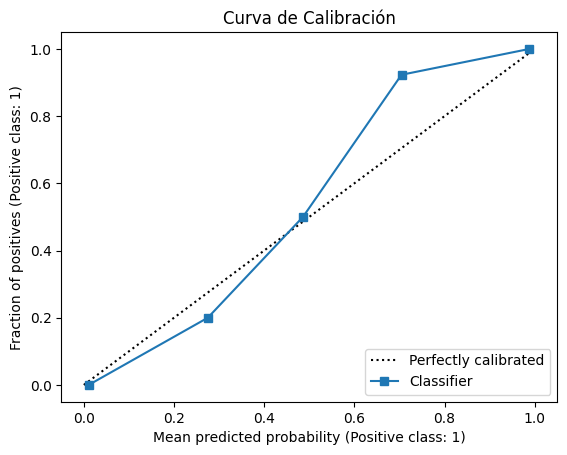

In [18]:
# Calibración del modelo
plt.figure(figsize=(10, 6))
CalibrationDisplay.from_predictions(y_test, model_probabilities)
plt.title("Curva de Calibración")
plt.show()


In [19]:
# Validación cruzada estratificada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X, y, cv=skf, scoring='accuracy')
print("\nScores de validación cruzada estratificada:", cv_scores)
print("Promedio de accuracy (validación cruzada):", cv_scores.mean())
print("Desviación estándar de accuracy:", cv_scores.std())



Scores de validación cruzada estratificada: [0.9989085  0.99872646 0.99963613 0.9989084  0.99927226]
Promedio de accuracy (validación cruzada): 0.9990903500683063
Desviación estándar de accuracy: 0.00032544225913318703


In [21]:
# Análisis de estabilidad de características
def feature_stability_analysis(X, y, model, n_iterations=10):
    feature_ranks = pd.DataFrame()

    for i in range(n_iterations):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
        model.fit(X_train, y_train)
        importances = pd.Series(model.feature_importances_, index=X.columns)
        feature_ranks[f'iter_{i}'] = importances.rank(ascending=False)

    stability_scores = feature_ranks.std(axis=1).sort_values(ascending=True)

    plt.figure(figsize=(10, 6))
    stability_scores.plot(kind='bar')
    plt.title("Estabilidad de Importancia de Características")
    plt.xlabel("Características")
    plt.ylabel("Desviación Estándar de Rankings")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return stability_scores


Analizando estabilidad de características...


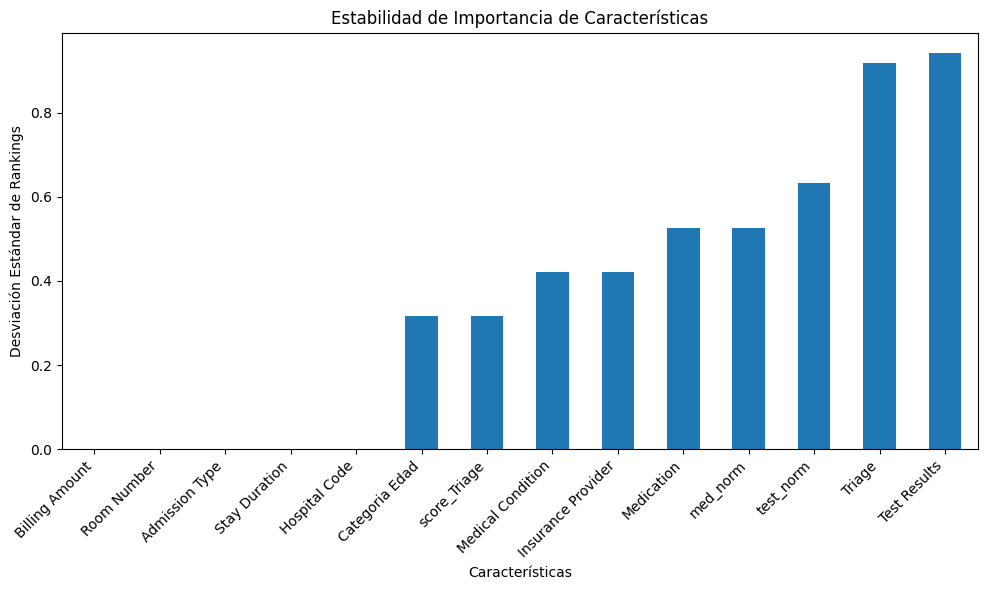

In [22]:
# Ejecutar análisis de estabilidad
print("\nAnalizando estabilidad de características...")
stability_scores = feature_stability_analysis(X, y, rf_model)
print("\nEstabilidad de características (menor es mejor):")
print(stability_scores)

In [23]:
import joblib

joblib.dump(rf_model, 'rf_model2.pkl')

['rf_model2.pkl']